In [37]:
reset -fs

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf
import statsmodels.api as sms
%matplotlib inline

In [39]:
#read in the file
horse = pd.read_csv('race-result-horse.csv')

In [64]:
#convert the finish_time to # of second
def convert_time(time_string):
    '''a function to convert string time to seconds'''
    return float(time_string.split('.')[0]) * 60 + float(time_string.split('.')[1]) + float(time_string.split('.')[2]) / 100

horse = horse[horse.finish_time != '---']
horse.finish_time = horse.finish_time.apply(convert_time)

In [65]:
#change the position from string to numeric
horse.finishing_position = pd.to_numeric(horse.finishing_position, errors = 'coerce')

In [72]:
#delete 'length_behind_winner' column
del horse['length_behind_winner']

In [79]:
#generate a category variable for winning or losing 
horse['winning'] = horse.finishing_position == 1

In [80]:
horse.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id,winning
0,1.0,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133.0,1032.0,1.0,1.0,2.0,2.0,1.0,82.33,3.8,NaN,NaN,2014-001,True
1,2.0,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,8.0,9.0,9.0,2.0,82.65,8.0,NaN,NaN,2014-001,False
2,3.0,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121.0,1065.0,3.0,2.0,1.0,1.0,3.0,82.66,5.7,NaN,NaN,2014-001,False
3,4.0,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132.0,1222.0,2.0,6.0,4.0,5.0,4.0,82.66,6.1,NaN,NaN,2014-001,False
4,5.0,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125.0,1136.0,9.0,9.0,10.0,10.0,5.0,83.02,6.1,NaN,NaN,2014-001,False


In [ ]:
"""generate some useful stats, such as the mean, median, mode of horse wight"""

In [5]:
"""find out that within each race, what charateristic does the winning horse have? 
  Does the weight contribute to the winning?
    compare the weight of the winning horse to the average weight of the horse in the same match. 
    treat this as a bernoulli trial and treat all the races as a series of bernoulli trail. Use MLE to estimate P, the 
    probability that higher than average and winning. 
"""

In [48]:
#generate a new data focusing on the the winning horse
horse_new = horse[horse.finishing_position == 1]

In [49]:
#reset the index and remove some redundent columns
horse_new.reset_index(inplace = True, drop = True)
del horse_new['finishing_position']
del horse_new['length_behind_winner']

In [53]:
#finding some descriptive statistic for the winning horse data
horse_new.declared_horse_weight.describe()

count    1557.000000
mean     1116.710983
std        58.789809
min       905.000000
25%      1077.000000
50%      1115.000000
75%      1155.000000
max      1301.000000
Name: declared_horse_weight, dtype: float64

In [59]:
#find the mean weight of horse within each race
aggmean = horse.groupby(['race_id'])['declared_horse_weight'].mean()

In [60]:
aggmean.head()

race_id
2014-001    1099.428571
2014-002    1114.214286
2014-003    1132.636364
2014-004    1100.000000
2014-005    1138.357143
Name: declared_horse_weight, dtype: float64

(array([   4.,   17.,  117.,  272.,  454.,  422.,  211.,   50.,   11.,    3.]),
 array([ 1031.375     ,  1047.30416667,  1063.23333333,  1079.1625    ,
         1095.09166667,  1111.02083333,  1126.95      ,  1142.87916667,
         1158.80833333,  1174.7375    ,  1190.66666667]),
 <a list of 10 Patch objects>)

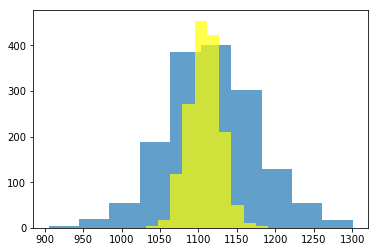

In [65]:
#compare the weight distribution between winnning horse the average of each race.
plt.hist(horse_new.declared_horse_weight, alpha = .7)
plt.hist(aggmean, color = 'yellow', alpha = .7)

ValueError: can not merge DataFrame with instance of type <class 'pandas.core.series.Series'>

In [6]:
"""how often does a low odd horse end up winning the race. 
    use the data with fin_pos = 1, calculate the distribution odd(cut them in bins) versus the times win"""

In [7]:
"""Does the draw of the gate have any influence toward the result. use the 'draw' column, use the whole data to find 
    relation between draws and finished position.
     

In [8]:
#under what finish time can a horse say winning a match most likely
"""use the winning data, plot the distribution of time, find the mean, mode and variance. Find a horse average run 
time, assume the horse will run at this time next time, what is the probabilty that it will finish first"""


"""select 13 horses in random, calcuate the average, calculate the odd base on the average. simulated the race result.
"""

In [45]:
horse.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id
0,1.0,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133.0,1032.0,1.0,-,1.0,2.0,2.0,1.0,1.22.33,3.8,NaN,NaN,2014-001
1,2.0,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,2,8.0,9.0,9.0,2.0,1.22.65,8.0,NaN,NaN,2014-001
2,3.0,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121.0,1065.0,3.0,2,2.0,1.0,1.0,3.0,1.22.66,5.7,NaN,NaN,2014-001
3,4.0,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132.0,1222.0,2.0,2,6.0,4.0,5.0,4.0,1.22.66,6.1,NaN,NaN,2014-001
4,5.0,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125.0,1136.0,9.0,4-1/4,9.0,10.0,10.0,5.0,1.23.02,6.1,NaN,NaN,2014-001


In [17]:
horse_new.dtypes

horse_number             float64
horse_name                object
horse_id                  object
jockey                    object
trainer                   object
actual_weight            float64
declared_horse_weight    float64
draw                     float64
running_position_1       float64
running_position_2       float64
running_position_3       float64
running_position_4       float64
finish_time               object
win_odds                 float64
running_position_5       float64
running_position_6       float64
race_id                   object
dtype: object

In [18]:
horse_new.shape

(1557, 17)

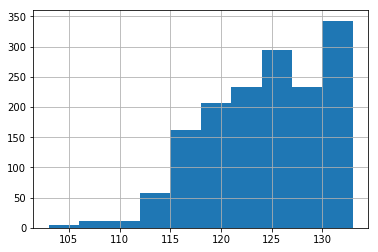

In [19]:
horse_new.actual_weight.hist()

In [20]:
horse_new.horse_name.value_counts().head()

CONTENTMENT          9
SERGEANT TITANIUM    7
SUN JEWELLERY        7
ABLE FRIEND          7
DASHING FELLOW       6
Name: horse_name, dtype: int64

In [21]:
#what is the relation between weight and winning. In which weight category does horse win the most?

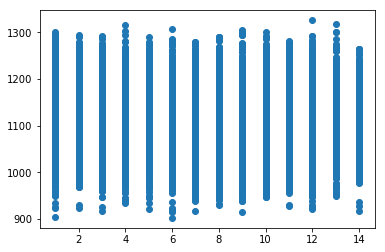

In [42]:
horse.groupby('[race_id]')['']